# Data Insights Take-Home: Clustering on Expenses and Revenues
**Marianne C. Halloran
October 12, 2017**
<br>
<br>
<p>*** The principal value of detailing the financial information obtained in Form 990 is to bring insight and arrive at data-backed conclusions about the NPOs, and their ability to garner financial support to continue operations. ***
Here, The idea is that, by understanding how a NPO obtains revenue and spends its funds, we will be better poised to understand its efficacy. It also answers the questions of the financial strength of the NPO (its ability to attract resources, level of reserves, financial accountability, etc).

#### Data selection rationale and visualizations
First, I generate visualizations of the sources of income for 501(c)(3) NPOs, based on fundraising, campaign, membership, government grants, gifts and service revenues. This can provide insights into the income nature of the NPOs. Some NPOs can receive most of their funds from chargings fees, or through government grants. *To some individuals, this can often play an important factor in their donation decision*.

Similarly, I generate visualizations of the expenses, based on functional, service, management, and fundraising expenses. Individuals interested in NPOs can be interested in how the NPOs are spending most of its resources on program matters and not on management or fundraising, for example. 

Net assets provide some indication of the level of resources the filer has to help support its activities in the future. 

Moreover, compensation of its employees versus its income and expenditure can bring important information about the NPOs and their financial health and resource allocation.

Here, I perform a basic clustering for three features: ***total compensation***, **total income plus assets**, and ***total expenses***. The idea behind this selection would  be to identify similar NPOs and the relationship between the three features: is there an inherent separation in the data?

#### Pre-processing and Clustering
Data was normalized using z-scores.
	
I chose ***z-score normalization*** although all data is given in dollars, these values necessarily comparable. Standardizing them using z-scores is a best-practice to give it equal weights by minimizing the error function using the Newton algorithm, i.e. a gradient-based optimization algorithm. Normalizing the data improves convergence of such algorithms.

**Suggestions:**

- Financial information is more meaningful if viewed over a period of several years, seeing how organizations can change over time. A single year's Form 990 provides only a snapshot in time. 

In [1]:
#=================================================================#
# LIBRARIES                                                       #
#=================================================================#
from __future__ import print_function
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from pylab import rcParams
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
rcParams['figure.figsize'] = 8,8

In [2]:
#=================================================================#
# DATA IMPPORT                                                    #
#=================================================================#
meta = pd.read_csv('input/NPO_meta_38k.csv')
meta.columns = ['EIN','contract_term','tax_status','org_name','city','state','tax_year',
                'activity','year_formed','volunteer_ct','employee_ct','rev_campaigns',
                'rev_membership', 'rev_fundraising','rev_govgrants','rev_other','rev_progserv',
                'rev_netfundraising','total_revenue','total_revenuePY','exp_grants','exp_progserv',
                'exp_management','exp_fundraising','total_expenses','total_compensations',
                'comp_more100k', 'net_assets','pol_act','lob_act','foreign_office',
                'foreign_fundraising','foreign_assist']
del meta['EIN'],  meta['contract_term']# meta['activity'],meta['year_formed'],
print(u"\u0011",'Cleaned data, removed NaN')


# I'm removing any organization that is not a 501(c)(3) and any orgs with NaN in a row
meta = meta.dropna(axis=0,how='any')
meta_501c3 = meta.loc[meta['tax_status'] == 0]
del meta; meta = meta_501c3
meta

 Cleaned data, removed NaN


,tax_status,org_name,city,state,tax_year,activity,year_formed,volunteer_ct,employee_ct,rev_campaigns,...,exp_fundraising,total_expenses,total_compensations,comp_more100k,net_assets,pol_act,lob_act,foreign_office,foreign_fundraising,foreign_assist
1,0,KBL LLP,BROOKLYN,NY,2014,0,0,0,0,0,...,0,115662,0,0,1843,1,1,1,2,2
2,0,Davis & Deal CPAs,GLENDORA,CA,2014,0,0,0,0,0,...,0,33918,0,0,54443,1,1,1,2,2
3,0,CBIZ Tofias,NEWPORT,RI,2014,0,0,0,0,0,...,0,7832,0,0,15049,1,1,1,2,2
4,0,RAYMOND F BOOK & ASSOCIATES PA,DOVER,DE,2014,TO PROVIDE EMERGENCY SHELTER FOR HOMELESS FAMI...,1988,250,15,0,...,0,464318,44864,0,731151,1,1,1,1,1
5,0,Larry D Sturgill CPA PC,WISE,VA,2014,TO PROVIDE SUPPORT TO THE LOCAL FIRE DEPARTMEN...,2007,6,0,0,...,0,27439,0,0,107296,1,1,1,1,1
6,0,MORGENSTERN WAXMAN ELLERSHAW,DETROIT,MI,2014,HELPS FAITH GROUPS WHO CARE FOR THE HOMELESS R...,2009,100,0,0,...,6107,384828,0,0,252121,1,1,1,1,1
7,0,Douglass Mischley and Associates,ELK GROVE,CA,2014,0,0,0,0,0,...,0,52857,0,0,6299,1,1,1,2,2
8,0,Chek Tan and Company,SAN FRANCISCO,CA,2014,0,0,0,0,0,...,0,19116,0,0,15794,1,1,1,2,2
9,0,RUBINO AND COMPANY CHARTERED,ROCKVILLE,MD,2014,TRANSPORTATION RELATED EDUCATION,1987,26,0,0,...,1673,50912,0,0,1547356,1,1,1,1,1
11,0,NEW HORIZON ACADEMY FOR EXCEPTIONAL STUDENTSINC,Ocala,FL,2013,0,0,0,0,0,...,0,162890,0,0,22472,1,1,1,2,2


In [3]:
#=================================================================#
# DESCRIPTIVE STATISTICS                                          #
#=================================================================#
print(u"\u0011",'Descriptive statistics, summarizing central tendency, dispersion')
print('  and shape of dataset\'s distribution')
meta.describe()

 Descriptive statistics, summarizing central tendency, dispersion
  and shape of dataset's distribution


,tax_status,tax_year,year_formed,volunteer_ct,employee_ct,rev_campaigns,rev_membership,rev_fundraising,rev_govgrants,rev_other,...,exp_fundraising,total_expenses,total_compensations,comp_more100k,net_assets,pol_act,lob_act,foreign_office,foreign_fundraising,foreign_assist
count,25244.0,25244.000000,25244.000000,2.524400e+04,25244.000000,2.524400e+04,2.524400e+04,2.524400e+04,2.524400e+04,2.524400e+04,...,2.524400e+04,2.524400e+04,2.524400e+04,25244.000000,2.524400e+04,25244.000000,25244.000000,25244.000000,25244.000000,25244.000000
mean,0.0,2013.980986,1220.854183,2.920713e+02,51.585723,8.171230e+03,1.752094e+04,3.250311e+04,2.637343e+05,5.857663e+05,...,5.191314e+04,5.480698e+06,1.235607e+05,2.677706,5.150527e+06,1.003209,1.009190,1.006338,1.341745,1.341745
std,0.0,0.136578,967.141939,1.449340e+04,477.381651,1.450932e+05,5.741884e+05,4.474750e+05,3.956428e+06,7.973029e+06,...,7.604113e+05,6.642740e+07,7.334543e+05,45.066658,6.115887e+07,0.056555,0.095426,0.079361,0.474304,0.474304
min,0.0,2013.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-8.310000e+02,-2.623100e+04,0.000000e+00,-1.856000e+03,...,-3.372700e+04,-2.581900e+04,-1.000000e+00,0.000000,-4.380901e+08,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.0,2014.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,5.825950e+04,0.000000e+00,0.000000,2.728050e+04,1.000000,1.000000,1.000000,1.000000,1.000000
50%,0.0,2014.000000,1972.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+02,...,0.000000e+00,1.858470e+05,0.000000e+00,0.000000,1.528275e+05,1.000000,1.000000,1.000000,1.000000,1.000000
75%,0.0,2014.000000,1997.000000,2.100000e+01,8.000000,0.000000e+00,0.000000e+00,2.362500e+03,0.000000e+00,1.551825e+05,...,1.620250e+03,7.495922e+05,5.000000e+04,0.000000,9.176578e+05,1.000000,1.000000,1.000000,2.000000,2.000000
max,0.0,2014.000000,2015.000000,2.000000e+06,36394.000000,1.203888e+07,6.755227e+07,5.801993e+07,5.147672e+08,7.624086e+08,...,8.391429e+07,4.232123e+09,3.254510e+07,2776.000000,5.057351e+09,2.000000,2.000000,2.000000,2.000000,2.000000


In [4]:
#=================================================================#
# PROCESS DATA: Categorical conversions, OHE, features            #
#=================================================================#
# Cities and States will get categorical codes
meta['city'] = meta['city'].str.upper() # all upper case
cities = sorted(meta['city'].unique())  # sort by unique names
meta['city_int'] = meta['city'].map(lambda x: cities.index(x))


 It is interesting that in average, most NPOs have almost zero profitability (Income minus Expense)


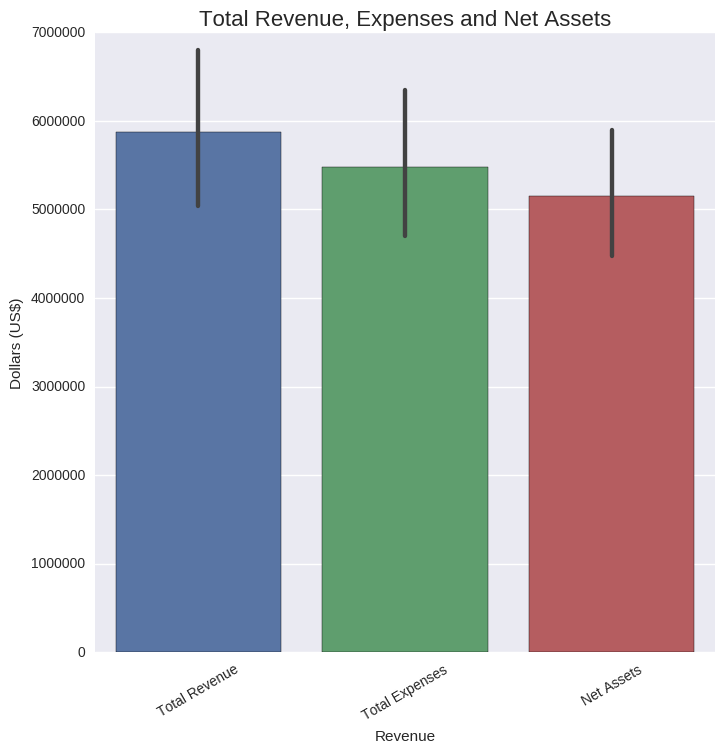

 Note that most NPOs' income comes from Program Services (23%) followed closely by income from Other sources (Gifts, Donations,etc) at 21%.  Government Grants only account for 8.8% of the total revenue


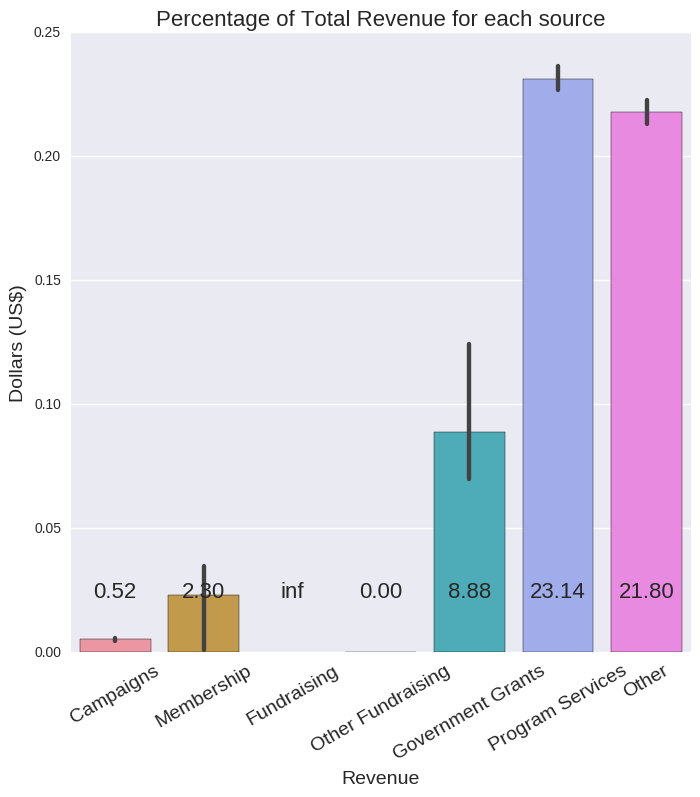

In [5]:
#=================================================================#
# VISUALIZATION                                                   #
#=================================================================#
# Visualizations of the sources of income for 501(c)(3) NPOs, 
# based on fundraising, campaign, membership, government grants, 
# gifts, assets and service revenues. This can provide insights into the 
# income nature of the NPOs. 
print(u"\u0011","It is interesting that in average, most NPOs have almost zero profitability (Income minus Expense)")
fig = plt.figure()
rev_df = meta[['total_revenue', 'total_expenses', 'net_assets']].copy()
ax = sns.barplot(data=rev_df)
ax.set(xlabel='Revenue', ylabel='Dollars (US$)')
ax.set_xticklabels(['Total Revenue','Total Expenses','Net Assets'], rotation=30)
ax.set_title('Total Revenue, Expenses and Net Assets', fontsize=16)
plt.show()

del rev_df
# Revenue Plot, normalized by total revenue
print(u"\u0011","Note that most NPOs' income comes from Program Services (23%)", 
      "followed closely by income from Other sources (Gifts, Donations,etc) at 21%. ",
      "Government Grants only account for 8.8% of the total revenue")
fig = plt.figure()
rev_df = meta[['rev_campaigns','rev_membership','rev_fundraising','rev_netfundraising',
               'rev_govgrants','rev_progserv','rev_other']].copy()

rev_df=(rev_df.div(meta['total_revenue'], axis=0)).fillna(0)
ax = sns.barplot(data=rev_df)
for p in ax.patches:
    ax.annotate("%.2f" % (p.get_height()*100),
                (p.get_x() + p.get_width() / 2., .02), 
                fontsize=16,ha='center', va='bottom')
ax.set_xlabel('Revenue', fontsize=14)
ax.set_xticklabels(['Campaigns','Membership','Fundraising','Other Fundraising',
                    'Government Grants', 'Program Services','Other'], rotation=30, fontsize=14)
ax.set_title('Percentage of Total Revenue for each source', fontsize=16)
ax.set_ylabel('Dollars (US$)',fontsize=14)
plt.show()


 Here, we see that, while Grants and Fundraising constitute only 8% of the expenses, Management/Functional and Compensations costs account, in average, for 22% of expenses.


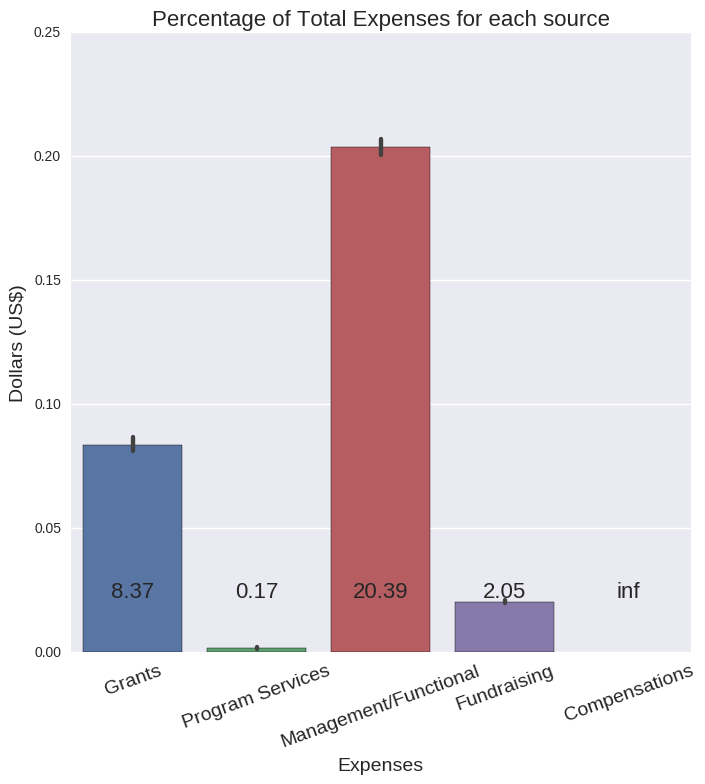

In [6]:
# Visualizations of the expenses, based on functional, service, 
# management, and fundraising expenses. 
# Normalized by total expenses
print(u"\u0011","Here, we see that, while Grants and Fundraising constitute only 8% of the expenses,",
      "Management/Functional and Compensations costs account, in average, for 22% of expenses.")
fig = plt.figure();
exp_df = meta[['exp_grants','exp_progserv','exp_management',
               'exp_fundraising', 'total_compensations']].copy()
exp_df=(exp_df.div(meta['total_expenses'], axis=0)).fillna(0)

ax = sns.barplot(data=exp_df)
for p in ax.patches:
    ax.annotate("%.2f" % (p.get_height()*100),
                (p.get_x() + p.get_width() / 2., .02), 
                fontsize=16,ha='center', va='bottom')
ax.set_xlabel('Expenses', fontsize=14)
ax.set_xticklabels(['Grants','Program Services','Management/Functional','Fundraising', 'Compensations'], rotation=20, fontsize=14)
ax.set_title('Percentage of Total Expenses for each source', fontsize=16)
ax.set_ylabel('Dollars (US$)',fontsize=14)
plt.show()

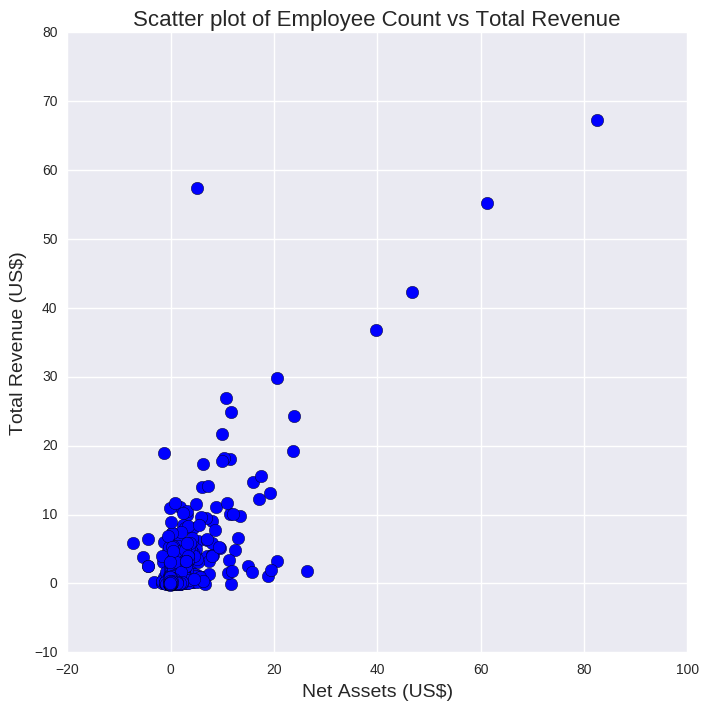

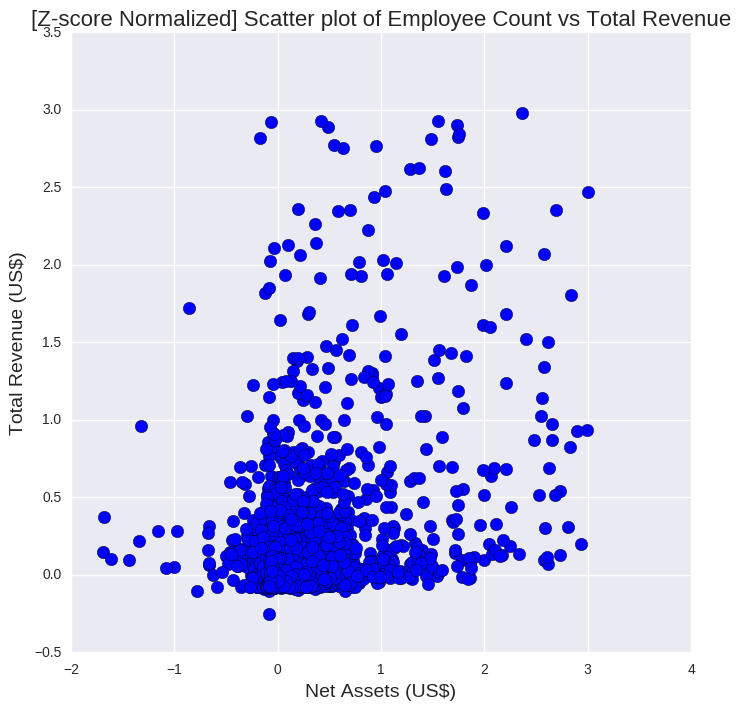

In [7]:
#=================================================================#
# VISUALIZATION                                                   #
#=================================================================#
## Create array for K-means
# Standarize (z-score) array (zi = xi-xmean/std)
meta_ = (meta[['net_assets', 'total_revenue']].copy()).apply(stats.zscore)
meta_zscored = meta_[(np.abs(stats.zscore(meta_)) < 3).all(axis=1)]

## Visualizations
plt.scatter(meta_['net_assets'], meta_['total_revenue'], s=80);
plt.title('Scatter plot of Employee Count vs Total Revenue', fontsize=16)
plt.xlabel('Net Assets (US$)', fontsize=14); plt.ylabel('Total Revenue (US$)', fontsize=14); 
plt.show()

plt.scatter(meta_zscored['net_assets'], meta_zscored['total_revenue'], s=80);
plt.title('[Z-score Normalized] Scatter plot of Employee Count vs Total Revenue', fontsize=16)
plt.xlabel('Net Assets (US$)', fontsize=14); plt.ylabel('Total Revenue (US$)', fontsize=14); 
plt.show()


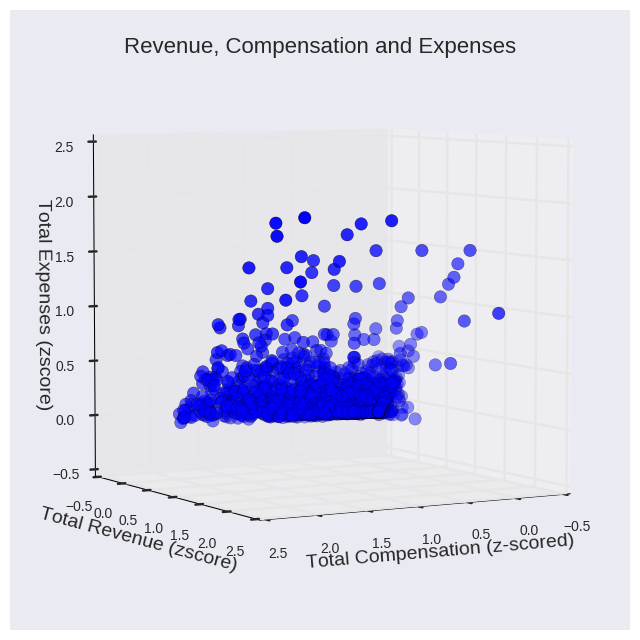

In [8]:
#=================================================================#
# 3D VISUALIZATION                                                #
#=================================================================#
# Add columns City_int and State_int to processed data
meta_ = (meta[['total_compensations', 'total_revenue', 'total_expenses']].copy()).apply(stats.zscore)
meta_zscored = meta_[(np.abs(stats.zscore(meta_)) < 2).all(axis=1)]

# 3D Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(meta_zscored['total_compensations'],meta_zscored['total_revenue'],meta_zscored['total_expenses'], s=80)
ax.set_xlabel('Total Compensation (z-scored)', fontsize=14)
ax.set_ylabel('Total Revenue (zscore)', fontsize=14)
ax.set_zlabel('Total Expenses (zscore)', fontsize=14)
ax.set_title('Revenue, Compensation and Expenses', fontsize=16)
ax.view_init(elev=5., azim=60)
plt.show()


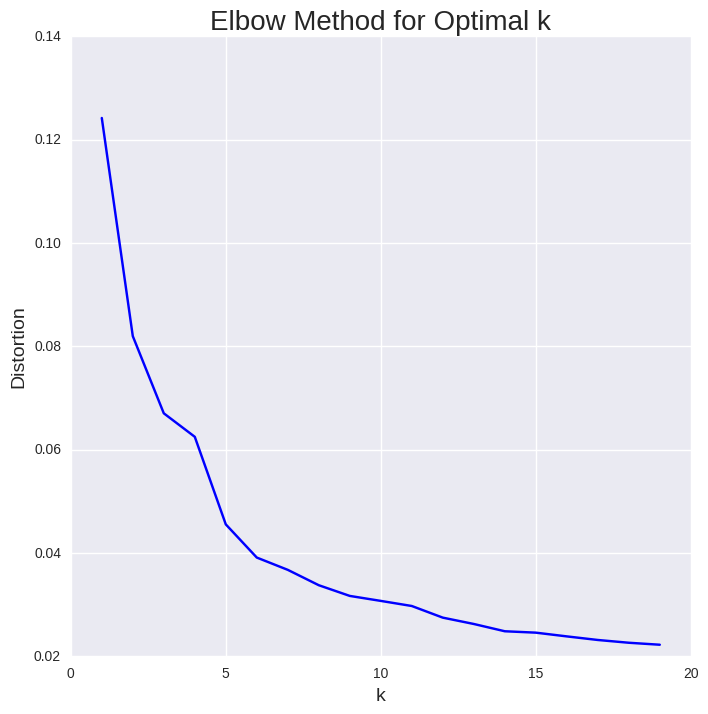

 Ideally, we would use a more stringent criterion determination method, such as the Akaike information criterion (AIC) or Bayesian information criterion (BIC)
.
 For k=4:           total_compensations  total_revenue  total_expenses
Clusters                                                    
0                   -0.142374      -0.072098       -0.073396
1                    1.227261       0.164052        0.171487
2                    0.289131       0.032820        0.031737
3                    1.096792       1.097198        1.059560


In [9]:
#=================================================================#
# K-Means Clustering                                              #
#=================================================================#
# Elbow method to determine K
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(meta_zscored)
    kmeanModel.fit(meta_zscored)
    distortions.append(sum(np.min(cdist(meta_zscored, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / meta_zscored.shape[0])
plt.plot(K, distortions, 'bx-')
plt.xlabel('k', fontsize=14)
plt.ylabel('Distortion', fontsize=14)
plt.title('Elbow Method for Optimal k', fontsize=20)
plt.show()
 
#=================================================================#
print(u"\u0011","Ideally, we would use a more stringent criterion determination method, such as",
      "the Akaike information criterion (AIC) or Bayesian information criterion (BIC)\n.")
# KMeans 
kmeans = KMeans(n_clusters=4, random_state=0).fit(meta_zscored)
labels = kmeans.labels_
## Add labels to original data
meta_zscored = meta_zscored.assign(Clusters = labels)
columns = (meta_zscored.columns.get_values()).tolist()
print(u"\u0011","For k=4:",meta_zscored[columns].groupby(['Clusters']).mean())


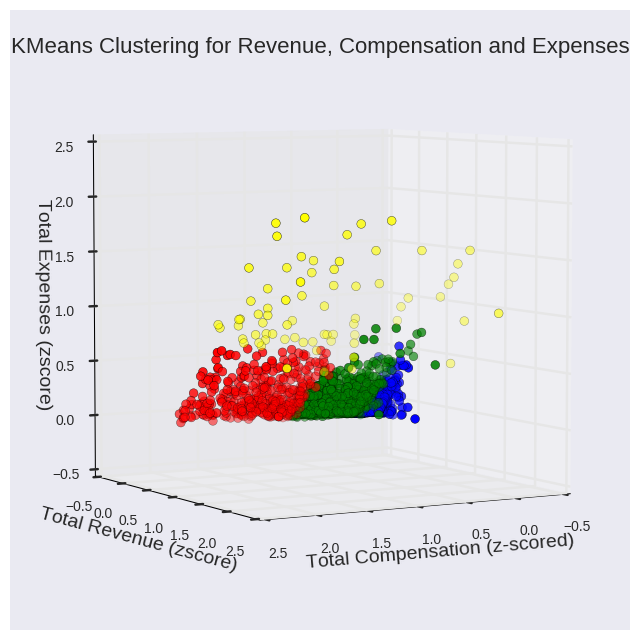

In [10]:
#=================================================================#
# VISUALIZATION K-Means Clustering                                #
#=================================================================#
# Generate cluster groupings
cluster1=meta_zscored.loc[meta_zscored['Clusters'] == 0]
cluster2=meta_zscored.loc[meta_zscored['Clusters'] == 1]
cluster3=meta_zscored.loc[meta_zscored['Clusters'] == 2]
cluster4=meta_zscored.loc[meta_zscored['Clusters'] == 3]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster1['total_compensations'],cluster1['total_revenue'],cluster1['total_expenses'], 
           c='blue', s=40, cmap="RdBu")
ax.scatter(cluster2['total_compensations'],cluster2['total_revenue'],cluster2['total_expenses'], 
           c='red', s=40, cmap="RdBu")
ax.scatter(cluster3['total_compensations'],cluster3['total_revenue'],cluster3['total_expenses'], 
           c='green', s=40, cmap="RdBu")
ax.scatter(cluster4['total_compensations'],cluster4['total_revenue'],cluster4['total_expenses'], 
           c='yellow', s=40, cmap="RdBu")
ax.set_xlabel('Total Compensation (z-scored)', fontsize=14)
ax.set_ylabel('Total Revenue (zscore)', fontsize=14)
ax.set_zlabel('Total Expenses (zscore)', fontsize=14)
ax.set_title('KMeans Clustering for Revenue, Compensation and Expenses', fontsize=16)
ax.view_init(elev=5., azim=60)
plt.show()

In [11]:
# Retrieve original data and clean NaNs due to zscore outlier removal
meta = meta.assign(Clusters = meta_zscored['Clusters'].loc[meta_zscored.index.get_values()])
meta = meta.dropna(axis=0,how='any')

 Cluster 1 contains  22960 companies with an average of 9.84 Employees and Average Compensation (Total) of US$19,137.95, with a mean of 0.049 employees receiving salaries above U$100k. 


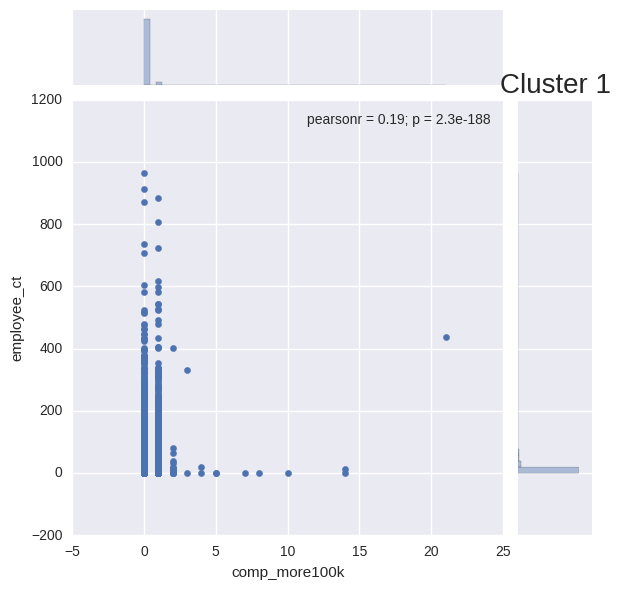

,tax_status,tax_year,year_formed,volunteer_ct,employee_ct,rev_campaigns,rev_membership,rev_fundraising,rev_govgrants,rev_other,...,total_compensations,comp_more100k,net_assets,pol_act,lob_act,foreign_office,foreign_fundraising,foreign_assist,city_int,Clusters
count,22960.0,22960.000000,22960.000000,22960.000000,22960.000000,2.296000e+04,2.296000e+04,2.296000e+04,2.296000e+04,2.296000e+04,...,22960.000000,22960.000000,2.296000e+04,22960.000000,22960.000000,22960.000000,22960.000000,22960.000000,22960.000000,22960.0
mean,0.0,2013.981533,1148.911237,83.683972,9.842030,5.527306e+03,7.269235e+03,1.674521e+04,8.791334e+04,1.936645e+05,...,19137.953876,0.049260,1.206294e+06,1.003528,1.010105,1.006969,1.375740,1.375740,2535.775174,0.0
std,0.0,0.134635,982.559518,1172.347520,38.282475,1.050532e+05,5.796567e+04,1.488328e+05,5.637834e+05,8.336638e+05,...,38767.347103,0.306391,7.863654e+06,0.059292,0.100014,0.083189,0.484324,0.484324,1495.537796,0.0
min,0.0,2013.000000,0.000000,0.000000,0.000000,0.000000e+00,-8.310000e+02,-2.623100e+04,0.000000e+00,-1.856000e+03,...,-1.000000,0.000000,-9.367646e+07,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.0
25%,0.0,2014.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,2.375450e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1136.000000,0.0
50%,0.0,2014.000000,1969.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,1.201860e+05,1.000000,1.000000,1.000000,1.000000,1.000000,2564.500000,0.0
75%,0.0,2014.000000,1998.000000,15.000000,4.000000,0.000000e+00,0.000000e+00,6.270000e+02,0.000000e+00,1.112815e+05,...,10000.000000,0.000000,6.060080e+05,1.000000,1.000000,1.000000,2.000000,2.000000,3867.000000,0.0
max,0.0,2014.000000,2015.000000,132183.000000,966.000000,6.705084e+06,2.559245e+06,1.574590e+07,2.621824e+07,4.789726e+07,...,194962.000000,21.000000,7.236827e+08,2.000000,2.000000,2.000000,2.000000,2.000000,5142.000000,0.0


In [12]:
#=================================================================#
# CLUSTER 1 ANALYSIS                                              #
#=================================================================#
print(u"\u0011","Cluster 1 contains ",len(cluster1), "companies", "with an average of 9.84 Employees and Average Compensation (Total) of US$19,137.95, with a mean of 0.049 employees receiving salaries above U$100k. ")
sns.jointplot(x="comp_more100k", y="employee_ct", data=meta.loc[meta['Clusters'] == 0]); 
plt.title('Cluster 1', fontsize=20); plt.show()
(meta.loc[meta['Clusters'] == 0]).describe()

 Cluster 2 contains 418 companies with an average of 246 Employees and Average Compensation (Total) of US$1,023,683.00, with a mean of 7.96 employees receiving salaries above U$100k. 


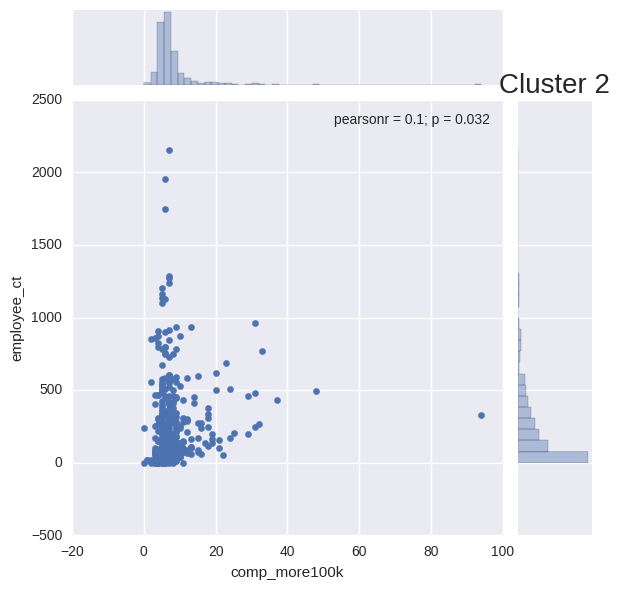

,tax_status,tax_year,year_formed,volunteer_ct,employee_ct,rev_campaigns,rev_membership,rev_fundraising,rev_govgrants,rev_other,...,total_compensations,comp_more100k,net_assets,pol_act,lob_act,foreign_office,foreign_fundraising,foreign_assist,city_int,Clusters
count,418.0,418.000000,418.000000,418.000000,418.000000,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,4.180000e+02,...,4.180000e+02,418.000000,4.180000e+02,418.0,418.0,418.0,418.0,418.0,418.000000,418.0
mean,0.0,2013.973684,1969.983254,718.490431,246.612440,1.525686e+04,1.317189e+05,2.055975e+05,1.440420e+06,2.717314e+06,...,1.023683e+06,7.964115,1.939036e+07,1.0,1.0,1.0,1.0,1.0,2673.593301,1.0
std,0.0,0.160265,101.174812,5800.562456,295.751999,1.068849e+05,7.371264e+05,6.932482e+05,3.192756e+06,5.816264e+06,...,2.535961e+05,6.886274,4.427482e+07,0.0,0.0,0.0,0.0,0.0,1496.085608,0.0
min,0.0,2013.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,6.299090e+05,0.000000,-9.836858e+07,1.0,1.0,1.0,1.0,1.0,2.000000,1.0
25%,0.0,2014.000000,1964.000000,0.000000,47.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.693000e+03,...,8.078035e+05,5.000000,2.353810e+06,1.0,1.0,1.0,1.0,1.0,1230.500000,1.0
50%,0.0,2014.000000,1982.000000,17.000000,145.000000,0.000000e+00,0.000000e+00,4.497000e+03,0.000000e+00,3.770885e+05,...,9.733300e+05,6.000000,7.808044e+06,1.0,1.0,1.0,1.0,1.0,2911.000000,1.0
75%,0.0,2014.000000,1996.000000,136.000000,337.500000,0.000000e+00,0.000000e+00,1.255680e+05,1.074418e+06,2.955950e+06,...,1.202543e+06,8.000000,1.864217e+07,1.0,1.0,1.0,1.0,1.0,3998.750000,1.0
max,0.0,2014.000000,2012.000000,108383.000000,2152.000000,1.483793e+06,8.436094e+06,9.011134e+06,2.230098e+07,5.123962e+07,...,1.588716e+06,94.000000,4.182555e+08,1.0,1.0,1.0,1.0,1.0,5116.000000,1.0


In [13]:
#=================================================================#
# CLUSTER 2 ANALYSIS                                              #
#=================================================================#
print(u"\u0011","Cluster 2 contains",len(cluster2), "companies", "with an average of 246 Employees and Average Compensation (Total) of US$1,023,683.00, with a mean of 7.96 employees receiving salaries above U$100k. ")
sns.jointplot(x="comp_more100k", y="employee_ct", data=meta.loc[meta['Clusters'] == 1]); 
plt.title('Cluster 2', fontsize=20); plt.show()
(meta.loc[meta['Clusters'] == 1]).describe()

 Cluster 3 contains  1357 companies with an average of 140 Employees and Average Compensation (Total) of US$335,620.96, with a mean of 1.86 employees receiving salaries above U$100k. 


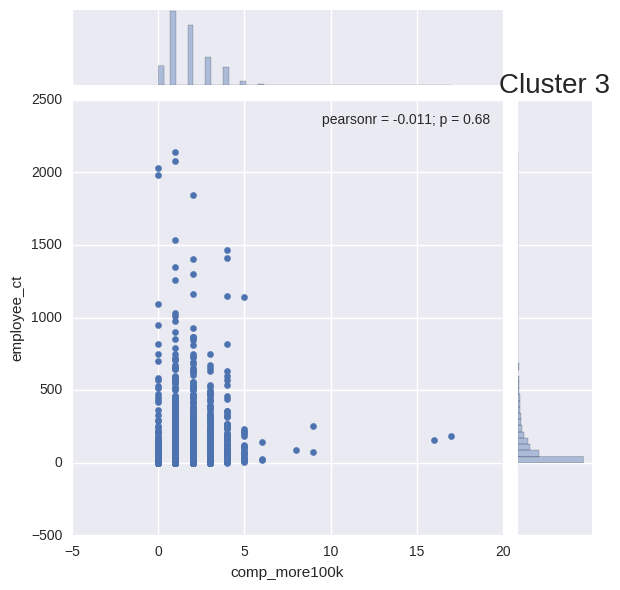

,tax_status,tax_year,year_formed,volunteer_ct,employee_ct,rev_campaigns,rev_membership,rev_fundraising,rev_govgrants,rev_other,...,total_compensations,comp_more100k,net_assets,pol_act,lob_act,foreign_office,foreign_fundraising,foreign_assist,city_int,Clusters
count,1357.0,1357.000000,1357.000000,1357.000000,1357.00000,1.357000e+03,1.357000e+03,1.357000e+03,1.357000e+03,1.357000e+03,...,1357.000000,1357.000000,1.357000e+03,1357.0,1357.0,1357.0,1357.0,1357.0,1357.000000,1357.0
mean,0.0,2013.977155,1937.671334,622.579956,140.24171,4.450973e+04,8.987204e+04,1.384135e+05,1.005672e+06,2.076691e+06,...,335620.968312,1.864407,1.160407e+07,1.0,1.0,1.0,1.0,1.0,2584.599116,2.0
std,0.0,0.149463,277.662639,3540.320084,232.07243,4.096323e+05,1.552164e+06,6.844131e+05,2.791158e+06,5.343337e+06,...,146062.701403,1.353203,3.110252e+07,0.0,0.0,0.0,0.0,0.0,1527.378489,0.0
min,0.0,2013.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,-2.108000e+03,0.000000e+00,0.000000e+00,...,0.000000,0.000000,-1.920838e+08,1.0,1.0,1.0,1.0,1.0,2.000000,2.0
25%,0.0,2014.000000,1965.000000,0.000000,15.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.340500e+04,...,217863.000000,1.000000,1.079231e+06,1.0,1.0,1.0,1.0,1.0,1095.000000,2.0
50%,0.0,2014.000000,1983.000000,25.000000,52.00000,0.000000e+00,0.000000e+00,1.643100e+04,0.000000e+00,4.834470e+05,...,291763.000000,2.000000,3.448855e+06,1.0,1.0,1.0,1.0,1.0,2813.000000,2.0
75%,0.0,2014.000000,1997.000000,200.000000,163.00000,0.000000e+00,0.000000e+00,8.094500e+04,4.890000e+05,1.768125e+06,...,437644.000000,2.000000,1.012193e+07,1.0,1.0,1.0,1.0,1.0,3953.000000,2.0
max,0.0,2014.000000,2014.000000,85000.000000,2141.00000,1.203888e+07,5.585967e+07,1.845267e+07,2.880526e+07,7.046836e+07,...,707697.000000,17.000000,4.012541e+08,1.0,1.0,1.0,1.0,1.0,5132.000000,2.0


In [14]:
#=================================================================#
# CLUSTER 3 ANALYSIS                                              #
#=================================================================#
print(u"\u0011","Cluster 3 contains ",len(cluster3), "companies", "with an average of 140 Employees and Average Compensation (Total) of US$335,620.96, with a mean of 1.86 employees receiving salaries above U$100k. ")
sns.jointplot(x="comp_more100k", y="employee_ct", data=meta.loc[meta['Clusters'] == 2]); 
plt.title('Cluster 3', fontsize=20); plt.show()
(meta.loc[meta['Clusters'] == 2]).describe()

 Similar to Cluster 3, Cluster 4 contains  71 companies with an average of 647 Employees and Average Compensation (Total) of US$927,991.6e+05, with a mean of 14.4 employees receiving salaries above U$100k. 


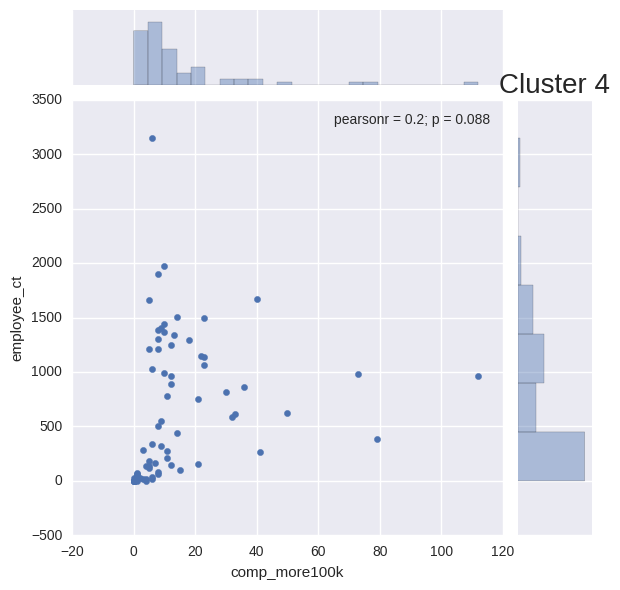

,tax_status,tax_year,year_formed,volunteer_ct,employee_ct,rev_campaigns,rev_membership,rev_fundraising,rev_govgrants,rev_other,...,total_compensations,comp_more100k,net_assets,pol_act,lob_act,foreign_office,foreign_fundraising,foreign_assist,city_int,Clusters
count,71.0,71.000000,71.000000,71.000000,71.000000,7.100000e+01,71.000000,7.100000e+01,7.100000e+01,7.100000e+01,...,7.100000e+01,71.000000,7.100000e+01,71.0,71.0,71.0,71.0,71.0,71.000000,71.0
mean,0.0,2013.971831,1964.281690,1814.338028,647.323944,3.152311e+04,3113.084507,1.846522e+05,6.518481e+06,1.862334e+07,...,9.279916e+05,14.408451,1.057232e+08,1.0,1.0,1.0,1.0,1.0,2696.676056,3.0
std,0.0,0.166633,37.291586,5377.264302,653.493115,2.057031e+05,19576.843685,5.000800e+05,1.895485e+07,3.488605e+07,...,4.782064e+05,19.266979,2.396360e+08,0.0,0.0,0.0,0.0,0.0,1406.318809,0.0
min,0.0,2013.000000,1828.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,-4.739637e+07,1.0,1.0,1.0,1.0,1.0,46.000000,3.0
25%,0.0,2014.000000,1943.500000,27.000000,67.500000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,4.530000e+02,...,6.689875e+05,4.500000,7.393938e+06,1.0,1.0,1.0,1.0,1.0,1876.500000,3.0
50%,0.0,2014.000000,1972.000000,94.000000,436.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,2.524770e+05,...,9.953440e+05,8.000000,3.969605e+07,1.0,1.0,1.0,1.0,1.0,2825.000000,3.0
75%,0.0,2014.000000,1992.500000,207.000000,1145.500000,0.000000e+00,0.000000,1.346700e+05,9.213875e+05,9.464749e+06,...,1.323695e+06,14.500000,9.688065e+07,1.0,1.0,1.0,1.0,1.0,3738.000000,3.0
max,0.0,2014.000000,2014.000000,28000.000000,3148.000000,1.717833e+06,154000.000000,3.341028e+06,1.007522e+08,1.489116e+08,...,1.588105e+06,112.000000,1.621377e+09,1.0,1.0,1.0,1.0,1.0,5085.000000,3.0


In [15]:
#=================================================================#
# CLUSTER 4 ANALYSIS                                              #
#=================================================================#
print(u"\u0011","Similar to Cluster 3, Cluster 4 contains ",len(cluster4), "companies", "with an average of 647 Employees and Average Compensation (Total) of US$927,991.6e+05, with a mean of 14.4 employees receiving salaries above U$100k. ")
sns.jointplot(x="comp_more100k", y="employee_ct", data=meta.loc[meta['Clusters'] == 3]); 
plt.title('Cluster 4', fontsize=20); plt.show()
(meta.loc[meta['Clusters'] == 3]).describe()

## Results from Clustering

My analysis identified 4 clusters of companies in database. As shown above, Clusters 1 and 3 contain companies that are relatively small (9.84 and 140 employees in average, respectively), but counted with only, in average 0.049 and 1.86 of its employees receiving salaries over U\$100,000, respectively. 

On the other hand, Clusters 2 and 4 show NPOs with a comparatively larger number of employees (246 and 647 in average, respectively), however, its average number of employees receiving remuneration of U$100,000 and higher exceeds Clusters 1 and 3 117-fold (0.095 versus 11.18 average for Clusters 1,3 and Clusters 2,4, respectively). The relationship between the Clusters and their Compensations and Revenues can be seen in Result Figures 1 and 2, below.

In Result Figure 2 and 3, I note that although NPOs in Cluster 4 are able to attract a larger amount of income, its number of volunteers varies greatly within the dataset, and is not much different from Clusters 2 and 3.

In addition, the three graphs below, show that revenues and expenses are also tied together for these clusters, and that the NPO clusters with highers revenues/expenses also count with the largest number of volunteers. 
Taken together, this data can help individuals and organizations best analyze the financial resources and its uses by the NPOs analyzed.

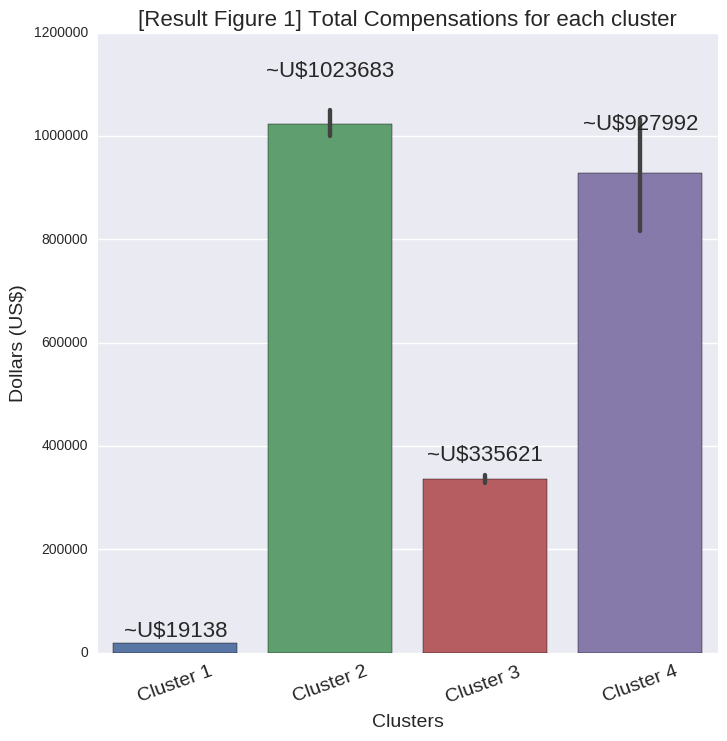

In [16]:
# Visualizations of the expenses, based on functional, service, 
# management, and fundraising expenses. 
# Normalized by total expenses
fig = plt.figure();
exp_df = meta[['total_compensations','Clusters']].copy()
exp_DF = exp_df.groupby(['Clusters'])
ax = sns.barplot(data=exp_df, x="Clusters", y="total_compensations", order=[0,1,2,3])
for p in ax.patches:
    ax.annotate("~U$%.0f" % (p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()*1.08), 
                fontsize=16,ha='center', va='bottom')
ax.set_xlabel('Clusters', fontsize=14)
ax.set_xticklabels(['Cluster 1','Cluster 2', 'Cluster 3 ','Cluster 4'], rotation=20, fontsize=14)
ax.set_title('[Result Figure 1] Total Compensations for each cluster', fontsize=16)
ax.set_ylabel('Dollars (US$)',fontsize=14)
plt.show()

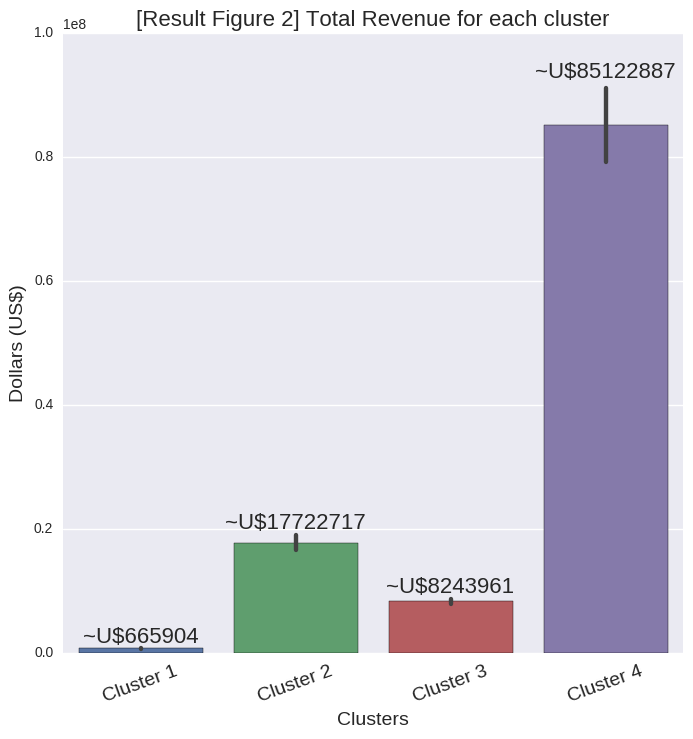

In [17]:
# Visualizations of the expenses, based on functional, service, 
# management, and fundraising expenses. 
# Normalized by total expenses
fig = plt.figure();
exp_df = meta[['total_revenue','Clusters']].copy()
exp_DF = exp_df.groupby(['Clusters'])
ax = sns.barplot(data=exp_df, x="Clusters", y="total_revenue", order=[0,1,2,3])
for p in ax.patches:
    ax.annotate("~U$%.0f" % (p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()*1.08), 
                fontsize=16,ha='center', va='bottom')
ax.set_xlabel('Clusters', fontsize=14)
ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3','Cluster 4'], rotation=20, fontsize=14)
ax.set_title('[Result Figure 2] Total Revenue for each cluster', fontsize=16)
ax.set_ylabel('Dollars (US$)',fontsize=14)
plt.show()

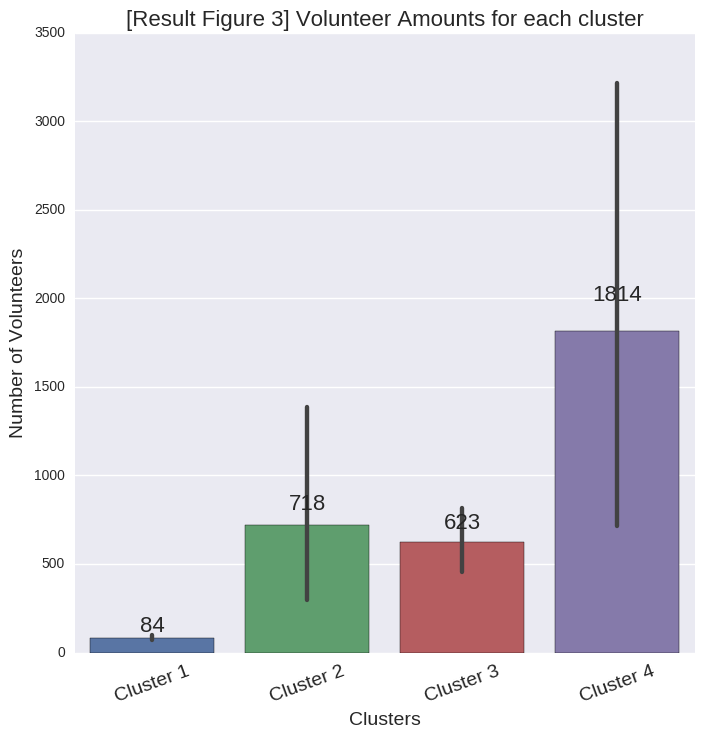

In [19]:
# Visualizations of the expenses, based on functional, service, 
# management, and fundraising expenses. 
# Normalized by total expenses
fig = plt.figure();
exp_df = meta[['volunteer_ct','Clusters']].copy()
exp_DF = exp_df.groupby(['Clusters'])
ax = sns.barplot(data=exp_df, x="Clusters", y="volunteer_ct", order=[0,1,2,3])
for p in ax.patches:
    ax.annotate("%.0f" % (p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()*1.08), 
                fontsize=16,ha='center', va='bottom')
ax.set_xlabel('Clusters', fontsize=14)
ax.set_xticklabels(['Cluster 1','Cluster 2', 'Cluster 3','Cluster 4'], rotation=20, fontsize=14)
ax.set_title('[Result Figure 3] Volunteer Amounts for each cluster', fontsize=16)
ax.set_ylabel('Number of Volunteers',fontsize=14)
plt.show()